In previous notebook we have showed how to build Perceptron and FCN. Here we will finally make Linear class that could handle different activations and any number of layers.

I didn't like the way fastai is handling exports since I do not like the idea of duplicating notebook to python files. Instead we can just have a helper that imports last (since last is usually final) occurance of the function or class in the notebook.

In [23]:
%load_ext autoreload
%autoreload 2

import math
import torch
from importer import import_from_nb

make_dataset = import_from_nb('2.1', 'make_dataset')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Note, that this way we can import objects that were defined using import_from_nb.

In [4]:
import_from_nb('2.2', 'make_dataset')

<function importer.make_dataset(level, n=100)>

Let's jump into implementation.

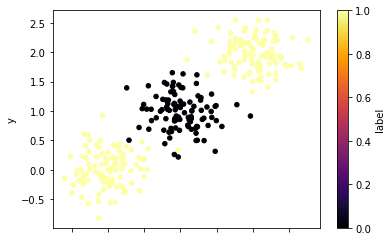

In [5]:
X, y = make_dataset('hard')

We will start with 3 layer implementation that ended up previous notebook

In [6]:
hidden = 4
epochs = 50
learning_rate = 0.4
W_0 = torch.normal(0., 1., (2, hidden))
B_0 = torch.zeros((hidden))
W_1 = torch.normal(0., 1., (hidden, hidden))
B_1 = torch.zeros((hidden))
W_2 = torch.normal(0., 1., (hidden, 1))
B_2 = torch.zeros((1))

act = torch.sigmoid
diff = lambda x: x * (1 - x)

for _ in range(epochs):
    for batch in range(10):
        X_batch = X[batch * 30:(1 + batch) * 30]
        y_batch = y[batch * 30:(1 + batch) * 30]

        L_1 = act(X_batch @ W_0 + B_0)
        L_2 = act(L_1 @ W_1 + B_1)
        L_3 = act(L_2 @ W_2 + B_2)
        errors = y_batch - L_3

        diff_3 = errors * diff(L_3)
        diff_2 = diff_3 @ W_2.T * diff(L_2) 
        diff_1 = diff_2 @ W_1.T * diff(L_1) 

        W_2 += learning_rate * L_2.T @ diff_3
        B_2 += learning_rate * torch.sum(diff_3)

        W_1 += learning_rate * L_1.T @ diff_2
        B_1 += learning_rate * torch.sum(diff_2)

        W_0 += learning_rate * X_batch.T @ diff_1
        B_0 += learning_rate * torch.sum(diff_1)

assert torch.mean(torch.abs(errors)) < 0.05

Before we go to full implementation, let's do this step by step. First we need activation and a linear layer.

In [7]:
class SigmoidActivation():
    def __call__(self, x):
        return torch.sigmoid(x)
    def diff(self, x):
        return x * (1 - x)
    
class LinearLayer():
    def __init__(self, shape, act):
        self.W = torch.normal(0., 1., shape)
        self.b = torch.zeros((shape[1]))
        self.act = act
    
    def __call__(self, x):
        return self.act(x @ self.W + self.b)

After introducing classes to the code we get

In [8]:
hidden = 4
epochs = 50
learning_rate = 0.4

sigmoid = SigmoidActivation()
layer_0 = LinearLayer((2, hidden), sigmoid)
layer_1 = LinearLayer((hidden, hidden), sigmoid)
layer_2 = LinearLayer((hidden, 1), sigmoid)

for _ in range(epochs):
    for batch in range(10):
        X_batch = X[batch * 30:(1 + batch) * 30]
        y_batch = y[batch * 30:(1 + batch) * 30]

        L_1 = layer_0(X_batch)
        L_2 = layer_1(L_1)
        L_3 = layer_2(L_2)
        errors = y_batch - L_3

        diff_3 = errors * layer_2.act.diff(L_3)
        diff_2 = diff_3 @ layer_2.W.T * layer_1.act.diff(L_2) 
        diff_1 = diff_2 @ layer_1.W.T * layer_0.act.diff(L_1) 

        layer_2.W += learning_rate * L_2.T @ diff_3
        layer_2.b += learning_rate * torch.sum(diff_3)

        layer_1.W += learning_rate * L_1.T @ diff_2
        layer_1.b += learning_rate * torch.sum(diff_2)

        layer_0.W += learning_rate * X_batch.T @ diff_1
        layer_0.b += learning_rate * torch.sum(diff_1)

assert torch.mean(torch.abs(errors)) < 0.05

Clearly we need to store details necessary for the backward pass in the Linear layer itself, thus let's refactor L1, L2 and L3.

In [9]:
class LinearLayer():
    def __init__(self, shape, act):
        self.W = torch.normal(0., 1., shape)
        self.b = torch.zeros((shape[1]))
        self.act = act
        self.out = None
    
    def __call__(self, x):
        self.out = self.act(x @ self.W + self.b)
        return self.out

    def back(self):
        return self.act.diff(self.out)

In [10]:
hidden = 4
epochs = 50
learning_rate = 0.4

sigmoid = SigmoidActivation()
layer_0 = LinearLayer((2, hidden), sigmoid)
layer_1 = LinearLayer((hidden, hidden), sigmoid)
layer_2 = LinearLayer((hidden, 1), sigmoid)

for _ in range(epochs):
    for batch in range(10):
        X_batch = X[batch * 30:(1 + batch) * 30]
        y_batch = y[batch * 30:(1 + batch) * 30]

        y_hat = layer_2(layer_1(layer_0(X_batch)))
        errors = y_batch - y_hat

        diff_3 = errors * layer_2.back()
        diff_2 = diff_3 @ layer_2.W.T * layer_1.back()
        diff_1 = diff_2 @ layer_1.W.T * layer_0.back()

        layer_0.W += learning_rate * X_batch.T @ diff_1
        layer_0.b += learning_rate * torch.sum(diff_1)

        layer_1.W += learning_rate * layer_0.out.T @ diff_2
        layer_1.b += learning_rate * torch.sum(diff_2)
        
        layer_2.W += learning_rate * layer_1.out.T @ diff_3
        layer_2.b += learning_rate * torch.sum(diff_3)

assert torch.mean(torch.abs(errors)) < 0.05

It would be nice if layer knows about the diff, then he could take a step.

In [11]:
class LinearLayer():
    def __init__(self, shape, act):
        self.W = torch.normal(0., 1., shape)
        self.b = torch.zeros((shape[1]))
        self.act = act
        self.out = None
        self.diff = None
    
    def __call__(self, x):
        self.out = self.act(x @ self.W + self.b)
        return self.out

    def back(self, mult):
        self.diff = mult * self.act.diff(self.out)
        return self.diff

In [12]:
hidden = 4
epochs = 50
learning_rate = 0.4

sigmoid = SigmoidActivation()
layer_0 = LinearLayer((2, hidden), sigmoid)
layer_1 = LinearLayer((hidden, hidden), sigmoid)
layer_2 = LinearLayer((hidden, 1), sigmoid)

for _ in range(epochs):
    for batch in range(10):
        X_batch = X[batch * 30:(1 + batch) * 30]
        y_batch = y[batch * 30:(1 + batch) * 30]

        y_hat = layer_2(layer_1(layer_0(X_batch)))
        errors = y_batch - y_hat

        layer_2.back(errors)
        layer_1.back(layer_2.diff @ layer_2.W.T)
        layer_0.back(layer_1.diff @ layer_1.W.T)

        layer_0.W += learning_rate * X_batch.T @ layer_0.diff
        layer_0.b += learning_rate * torch.sum(layer_0.diff)

        layer_1.W += learning_rate * layer_0.out.T @ layer_1.diff
        layer_1.b += learning_rate * torch.sum(layer_1.diff)
        
        layer_2.W += learning_rate * layer_1.out.T @ layer_2.diff
        layer_2.b += learning_rate * torch.sum(layer_2.diff)

assert torch.mean(torch.abs(errors)) < 0.05

Now it's easy to see that simply changing the return statement of back we can reduce it even further

In [13]:
class LinearLayer():
    def __init__(self, shape, act):
        self.W = torch.normal(0., 1., shape)
        self.b = torch.zeros((shape[1]))
        self.act = act
        self.out = None
        self.diff = None
    
    def __call__(self, x):
        self.out = self.act(x @ self.W + self.b)
        return self.out

    def back(self, mult):
        self.diff = mult * self.act.diff(self.out)
        return self.diff @ self.W.T

In [14]:
hidden = 4
epochs = 50
learning_rate = 0.4

sigmoid = SigmoidActivation()
layer_0 = LinearLayer((2, hidden), sigmoid)
layer_1 = LinearLayer((hidden, hidden), sigmoid)
layer_2 = LinearLayer((hidden, 1), sigmoid)

for _ in range(epochs):
    for batch in range(10):
        X_batch = X[batch * 30:(1 + batch) * 30]
        y_batch = y[batch * 30:(1 + batch) * 30]

        y_hat = layer_2(layer_1(layer_0(X_batch)))
        errors = y_batch - y_hat

        layer_0.back(layer_1.back(layer_2.back(errors)))

        layer_0.W += learning_rate * X_batch.T @ layer_0.diff
        layer_0.b += learning_rate * torch.sum(layer_0.diff)

        layer_1.W += learning_rate * layer_0.out.T @ layer_1.diff
        layer_1.b += learning_rate * torch.sum(layer_1.diff)
        
        layer_2.W += learning_rate * layer_1.out.T @ layer_2.diff
        layer_2.b += learning_rate * torch.sum(layer_2.diff)

assert torch.mean(torch.abs(errors)) < 0.05

Nice, now let's observe that layers know about their inputs, thus can take a step. By they way we can improve our init using division from `math.sqrt(fan_in)`.

In [27]:
class LinearLayer():
    def __init__(self, shape, act):
        self.W = torch.randn(shape) / math.sqrt(shape[0])
        self.b = torch.zeros((shape[1]))
        self.act = act
        self.inp = None
        self.out = None
        self.diff = None
    
    def __call__(self, x):
        self.inp = x
        self.out = self.act(x @ self.W + self.b)
        return self.out

    def back(self, mult):
        self.diff = mult * self.act.diff(self.out)
        return self.diff @ self.W.T
    
    def step(self, learning_rate):
        self.W += learning_rate * self.inp.T @ self.diff
        self.b += learning_rate * torch.sum(self.diff)

In [32]:
hidden = 4
epochs = 50
learning_rate = 0.4

sigmoid = SigmoidActivation()
layer_0 = LinearLayer((2, hidden), sigmoid)
layer_1 = LinearLayer((hidden, hidden), sigmoid)
layer_2 = LinearLayer((hidden, 1), sigmoid)

for _ in range(epochs):
    for batch in range(10):
        X_batch = X[batch * 30:(1 + batch) * 30]
        y_batch = y[batch * 30:(1 + batch) * 30]

        y_hat = layer_2(layer_1(layer_0(X_batch)))
        errors = y_batch - y_hat

        layer_0.back(layer_1.back(layer_2.back(errors)))
        
        layer_0.step(learning_rate)
        layer_1.step(learning_rate)
        layer_2.step(learning_rate)

assert torch.mean(torch.abs(errors)) < 0.05

From there we just need to abstrack sequential model.

In [30]:
class Sequential():
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        out = x
        for l in self.layers:
            out = l(out)
        return out
    
    def back(self, x):
        out = x
        for l in self.layers[::-1]:
            out = l.back(out)
        return out
    
    def step(self, lr):
        for l in self.layers:
            l.step(lr)

In [31]:
hidden = 4
epochs = 50
learning_rate = 0.4

sigmoid = SigmoidActivation()
model = Sequential([LinearLayer((2, hidden), sigmoid),
                    LinearLayer((hidden, hidden), sigmoid),
                    LinearLayer((hidden, 1), sigmoid)])

for _ in range(epochs):
    for batch in range(10):
        X_batch = X[batch * 30:(1 + batch) * 30]
        y_batch = y[batch * 30:(1 + batch) * 30]

        y_hat = model(X_batch)
        errors = y_batch - y_hat

        model.back(errors)
        model.step(learning_rate)

assert torch.mean(torch.abs(errors)) < 0.05

At the moment our optimizer ended up in the model itself, but we can easily take it out if needed.